In [5]:
pip install yfinance pandas_datareader openpyxl


In [6]:
START_DATE = "2005-01-01"
END_DATE   = "2025-12-31"


In [7]:
import yfinance as yf
import pandas as pd
import os

tickers = ["SPY", "TLT", "GLD", "DBC", "UUP", "SHY", "CL=F", "GC=F"]

market_data = yf.download(
    tickers,
    start="2005-01-01",
    end="2025-12-31",
    auto_adjust=True
)["Close"]

# Create the directory if it doesn't exist
os.makedirs('data/processed', exist_ok=True)
market_data.to_csv("data/processed/market_prices.csv")

[*********************100%***********************]  8 of 8 completed


In [8]:
from pandas_datareader import data as pdr

fred_series = [
    "DGS10",
    "FEDFUNDS",
    "CPIAUCSL",
    "PPIACO",
    "T10Y2Y",
    "DTWEXBGS",
    "INDPRO",
    "TEDRATE",
    "STLFSI2"
]

fred_data = pd.DataFrame()

for series in fred_series:
    fred_data[series] = pdr.DataReader(series, "fred", START_DATE, END_DATE)

fred_data.to_csv("data/processed/macro_fred.csv")


In [9]:
import os
import pandas as pd

macro_folder = "/content/" # Changed path to where files actually are

macro_df = pd.DataFrame()

# List of files in the macro_folder to process, filter only csv and xlsx
files_to_process = [f for f in os.listdir(macro_folder) if f.endswith(".csv") or f.endswith(".xlsx")]

if not files_to_process:
    print(f"No .csv or .xlsx files found in {macro_folder}. 'macro_df' will be empty.")

for file_name in files_to_process:
    file_path = os.path.join(macro_folder, file_name)
    temp = None
    if file_name.endswith(".csv"):
        temp = pd.read_csv(file_path)
    elif file_name.endswith(".xlsx"):
        temp = pd.read_excel(file_path)

    if temp is not None:
        # Check if the DataFrame has at least two columns for DATE and value
        if len(temp.columns) >= 2:
            # Select the first two columns, rename them, process date, and set index
            temp = temp.iloc[:, :2] # Select first two columns
            temp.columns = ["DATE", file_name.split(".")[0]] # Rename to DATE and series name
            temp["DATE"] = pd.to_datetime(temp["DATE"])
            temp.set_index("DATE", inplace=True)
            macro_df = pd.concat([macro_df, temp], axis=1)
        else:
            print(f"Skipping {file_name} as it does not have at least two columns for DATE and value.")

# Ensure the output directory exists
os.makedirs('data/processed', exist_ok=True)
macro_df.to_csv("data/processed/macro_local.csv")

In [10]:
vix = yf.download("^VIX", start=START_DATE, end=END_DATE)["Close"]
vix.to_csv("data/processed/vix.csv")


/tmp/ipython-input-332617782.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=START_DATE, end=END_DATE)["Close"]
[*********************100%***********************]  1 of 1 completed


In [11]:
market = pd.read_csv("data/processed/market_prices.csv", index_col=0, parse_dates=True)
macro  = pd.read_csv("data/processed/macro_fred.csv", index_col=0, parse_dates=True)
vix    = pd.read_csv("data/processed/vix.csv", index_col=0, parse_dates=True)

data = market.join(macro, how="outer")
data = data.join(vix, how="outer")

data.sort_index(inplace=True)
data.to_csv("data/processed/full_raw_dataset.csv")


In [12]:
print(data.isna().sum())
print(data.describe())
print(data.index.min(), data.index.max())


CL=F         197
DBC          471
GC=F         201
GLD          196
SHY          196
SPY          196
TLT          196
UUP          738
DGS10        225
FEDFUNDS    5298
CPIAUCSL    5299
PPIACO      5298
T10Y2Y       225
DTWEXBGS     465
INDPRO      5298
TEDRATE     1291
STLFSI2     4590
^VIX         196
dtype: int64
              CL=F          DBC         GC=F          GLD          SHY  \
count  5281.000000  5007.000000  5277.000000  5282.000000  5282.000000   
mean     71.530009    18.937384  1438.976785   136.676323    69.263724   
std      21.015795     4.911249   656.332969    59.380642     6.371400   
min     -37.630001     9.136448   412.600006    41.259998    54.445194   
25%      56.230000    14.275213  1104.500000   107.115000    66.851576   
50%      69.860001    20.069118  1310.599976   125.139999    69.831100   
75%      86.790001    21.922197  1757.099976   166.479996    73.637999   
max     145.289993    38.652573  4529.100098   416.739990    82.600418   

              

In [13]:
macro = pd.read_csv("data/processed/macro_fred.csv", index_col=0, parse_dates=True)

macro_monthly = macro.resample("M").last()
macro_monthly.to_csv("data/processed/macro_monthly.csv")


/tmp/ipython-input-3354005001.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_monthly = macro.resample("M").last()


In [14]:
market = pd.read_csv("data/processed/market_prices.csv", index_col=0, parse_dates=True)

returns_daily = market.pct_change().dropna()

returns_monthly = (1 + returns_daily).resample("M").prod() - 1
returns_monthly.to_csv("data/processed/returns_monthly.csv")


/tmp/ipython-input-1327005039.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = market.pct_change().dropna()
/tmp/ipython-input-1327005039.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = (1 + returns_daily).resample("M").prod() - 1


In [15]:
vix = pd.read_csv("data/processed/vix.csv", index_col=0, parse_dates=True)

vix_monthly = vix.resample("M").mean()

macro_regime_df = macro_monthly.join(vix_monthly, how="inner")
macro_regime_df.dropna(inplace=True)

macro_regime_df.to_csv("data/processed/macro_regime_matrix.csv")


/tmp/ipython-input-3149192060.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_monthly = vix.resample("M").mean()


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_regime_df)

import numpy as np
np.save("data/processed/macro_scaled.npy", macro_scaled)


In [17]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.8 MB/s eta 0:00:00


In [18]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

Z = np.load("data/processed/macro_scaled.npy")

results = []

for n in [2, 3, 4]:
    model = GaussianHMM(
        n_components=n,
        covariance_type="full",
        n_iter=2000,
        random_state=42
    )

    model.fit(Z)

    log_likelihood = model.score(Z)
    bic = model.bic(Z)
    aic = model.aic(Z)

    results.append({
        "regimes": n,
        "log_likelihood": log_likelihood,
        "BIC": bic,
        "AIC": aic
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


   regimes  log_likelihood          BIC          AIC
0        2     -522.210228  1698.777919  1310.420456
1        3     -632.289249  2263.334627  1670.578499
2        4       93.492696  1166.009363   363.014609


In [22]:
best_n = results_df.sort_values("BIC").iloc[0]["regimes"]

best_model = GaussianHMM(
    n_components=int(best_n),
    covariance_type="full",
    n_iter=2000,
    random_state=42
)

best_model.fit(Z)

regimes = best_model.predict(Z)
regime_probs = best_model.predict_proba(Z)
regime_probs

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [2.20506738e-115, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [8.21127772e-103, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [7.86003008e-096, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [2.83367429e-092, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [5.47851351e-097, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [1.47923814e-098, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [4.36981793e-087, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [1.06585263e-065, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [3.83939244e-050, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [1.02655422e-030, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000],
       [3.28798476e-017, 0.00000000e+000, 0.00000000e+000,
      

In [20]:
macro_regime_df["regime"] = regimes


In [23]:
returns_monthly = pd.read_csv(
    "data/processed/returns_monthly.csv",
    index_col=0,
    parse_dates=True
)

macro_regime_df = macro_regime_df.join(
    returns_monthly["SPY"],
    how="inner"
)


In [24]:
regime_stats = macro_regime_df.groupby("regime")["SPY"].agg([
    "mean",
    "std",
    "min",
    "max"
])

print(regime_stats)


            mean       std       min       max
regime                                        
0      -0.027774  0.059131 -0.165186  0.047662
1       0.015682  0.036338 -0.069105  0.126983
2       0.014954  0.038149 -0.069421  0.099346
3       0.011304  0.024439 -0.014620  0.033920


In [25]:
transition_matrix = best_model.transmat_

import pandas as pd
transition_df = pd.DataFrame(
    transition_matrix,
    columns=[f"to_{i}" for i in range(4)],
    index=[f"from_{i}" for i in range(4)]
)

print(transition_df)


                 to_0      to_1          to_2          to_3
from_0   9.230769e-01  0.000000  7.692308e-02  1.011392e-68
from_1   0.000000e+00  1.000000  2.608690e-39  0.000000e+00
from_2  3.486825e-178  0.017544  9.824558e-01  0.000000e+00
from_3   7.692308e-02  0.000000  0.000000e+00  9.230769e-01


# **REGIME PERSISTENCE**

Expected duration formula:

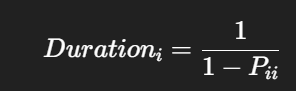

In [26]:
import numpy as np

persistence = 1 / (1 - np.diag(transition_matrix))

print(pd.Series(persistence, name="Expected_Duration_Months"))


0    13.000000
1          inf
2    56.998896
3    13.000000
Name: Expected_Duration_Months, dtype: float64


/tmp/ipython-input-1268283064.py:3: RuntimeWarning: divide by zero encountered in divide
  persistence = 1 / (1 - np.diag(transition_matrix))


# **Interpretation:**

If expected duration < 2 months → noise.

If 6–24 months → real structural regime.

# **VOLATILITY PER REGIME**

Compute monthly volatility per regime.

In [27]:
macro_regime_df["SPY_vol"] = macro_regime_df["SPY"].rolling(3).std()

vol_stats = macro_regime_df.groupby("regime")["SPY_vol"].mean()

print(vol_stats)


regime
0    0.044963
1    0.033843
2    0.035291
3    0.024439
Name: SPY_vol, dtype: float64


# **DRAWDOWN PER REGIME**

In [28]:
macro_regime_df["SPY_cum"] = (1 + macro_regime_df["SPY"]).cumprod()
macro_regime_df["SPY_peak"] = macro_regime_df["SPY_cum"].cummax()
macro_regime_df["drawdown"] = (
    macro_regime_df["SPY_cum"] - macro_regime_df["SPY_peak"]
) / macro_regime_df["SPY_peak"]

dd_stats = macro_regime_df.groupby("regime")["drawdown"].min()

print(dd_stats)


regime
0   -0.340033
1   -0.072503
2   -0.274468
3   -0.014620
Name: drawdown, dtype: float64


# **LAYER 2 — DAILY VOLATILITY ENGINE (MS-GARCH FRAMEWORK)**

In [29]:
import pandas as pd
import numpy as np

market = pd.read_csv(
    "data/processed/market_prices.csv",
    index_col=0,
    parse_dates=True
)

returns_daily = market.pct_change().dropna()

spy_ret = returns_daily["SPY"] * 100  # scale for GARCH stability


/tmp/ipython-input-4124007948.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = market.pct_change().dropna()


In [30]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 52.8 MB/s eta 0:00:00


In [31]:
from arch import arch_model

garch = arch_model(
    spy_ret,
    vol="Garch",
    p=1,
    q=1,
    dist="t"
)

garch_fit = garch.fit(disp="off")

vol_daily = garch_fit.conditional_volatility


In [32]:
garch_fit

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6318.25
Distribution:      Standardized Student's t   AIC:                           12646.5
Method:                  Maximum Likelihood   BIC:                           12678.8
                                              No. Observations:                 4741
Date:                      Sun, Feb 15 2026   Df Residuals:                     4740
Time:                              05:42:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [33]:
vol_daily

,cond_vol
Date,
2007-03-02,0.864670
2007-03-05,0.978468
2007-03-06,0.999440
2007-03-07,1.122321
2007-03-08,1.043682
...,...
2025-12-23,0.777145
2025-12-24,0.740832
2025-12-26,0.701848


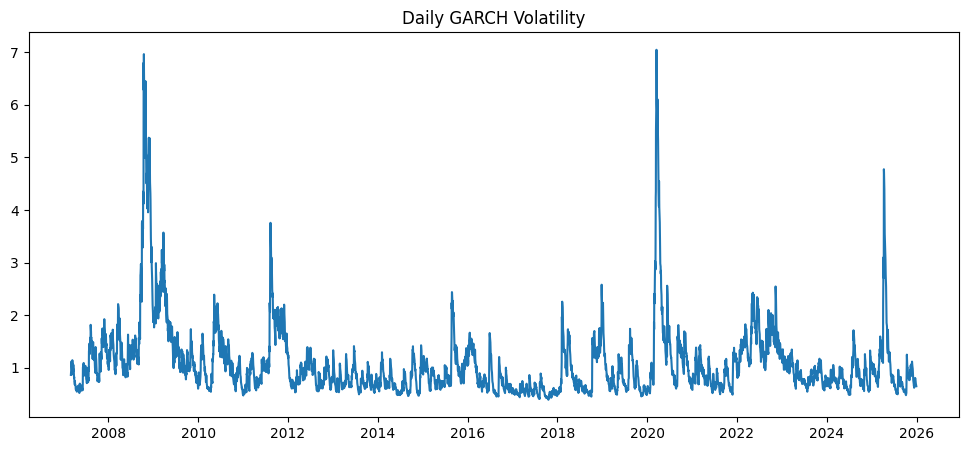

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(vol_daily)
plt.title("Daily GARCH Volatility")
plt.show()


In [35]:
import pandas as pd

# Reconstruct macro_regime_df to ensure it contains 'regime' and 'SPY' columns
# These variables should be available from previous cell executions:
# macro_monthly (from NYncSJ2RClin)
# vix_monthly (from I9n5TtX6Cq_7)
# regimes (from IuvUvfsBDWvb)
# returns_monthly (from kAzuuMZWCmg_)
# spy_ret (from uRjFiSv7KFgu)

# Recreate the base macro_regime_df from macro_monthly and vix_monthly
macro_regime_df = macro_monthly.join(vix_monthly, how="inner")
macro_regime_df.dropna(inplace=True)

# Add the 'regime' column from the 'regimes' array
# Ensure alignment by assigning directly, as 'regimes' length should match macro_regime_df at this point
macro_regime_df["regime"] = regimes

# Join SPY returns to macro_regime_df
macro_regime_df = macro_regime_df.join(returns_monthly["SPY"], how="inner")

monthly_regime = macro_regime_df["regime"]

daily_regime = monthly_regime.reindex(
    spy_ret.index,
    method="ffill"
)

In [36]:
regime_vols = {}

for r in sorted(daily_regime.unique()):

    mask = daily_regime == r
    ret_subset = spy_ret[mask]

    if len(ret_subset) > 500:  # avoid tiny samples

        model = arch_model(ret_subset, p=1, q=1, dist="t")
        fit = model.fit(disp="off")

        regime_vols[r] = fit.conditional_volatility.mean()


In [37]:
vol_base = vol_daily

regime_multiplier = daily_regime.map({
    0: 0.8,
    1: 1.0,
    2: 1.8,
    3: 1.2
})

vol_adjusted = vol_base * regime_multiplier


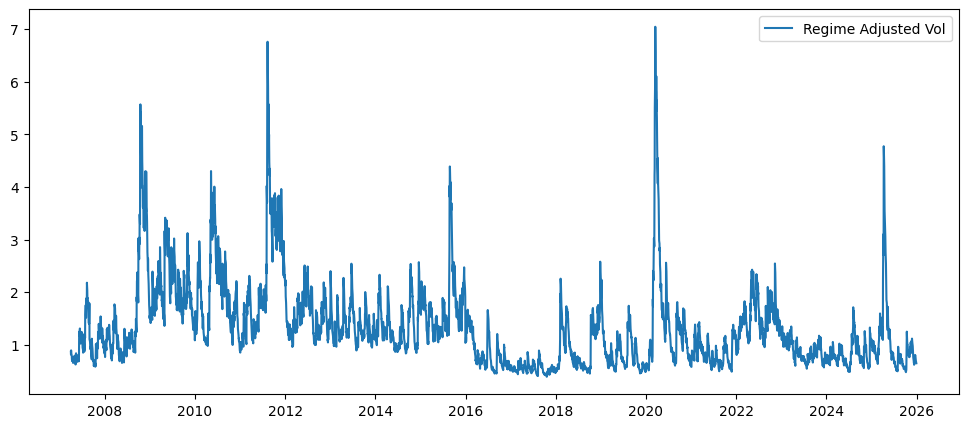

In [38]:
plt.figure(figsize=(12,5))
plt.plot(vol_adjusted, label="Regime Adjusted Vol")
plt.legend()
plt.show()


In [39]:
spy_ret = returns_daily["SPY"]
spy_ret

,SPY
Date,
2007-03-02,-0.013095
2007-03-05,-0.009519
2007-03-06,0.017110
2007-03-07,-0.001003
2007-03-08,0.008456
...,...
2025-12-23,0.004570
2025-12-24,0.003518
2025-12-26,-0.000101


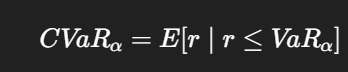

In [40]:
import numpy as np

def rolling_cvar(series, window=252, alpha=0.05):
    cvar = []

    for i in range(window, len(series)):
        window_data = series.iloc[i-window:i]
        var = np.percentile(window_data, 100*alpha)
        tail_losses = window_data[window_data <= var]
        cvar.append(tail_losses.mean())

    return pd.Series(cvar, index=series.index[window:])


In [41]:
cvar_5 = rolling_cvar(spy_ret, window=252, alpha=0.05)
cvar_5

,0
Date,
2008-03-03,-0.025150
2008-03-04,-0.025150
2008-03-05,-0.025150
2008-03-06,-0.025150
2008-03-07,-0.025150
...,...
2025-12-23,-0.027484
2025-12-24,-0.027484
2025-12-26,-0.027484


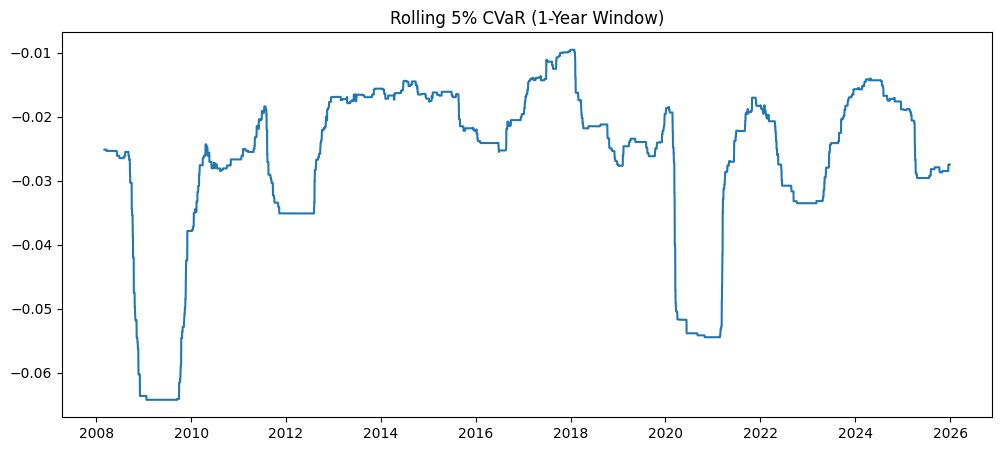

In [42]:
plt.figure(figsize=(12,5))
plt.plot(cvar_5)
plt.title("Rolling 5% CVaR (1-Year Window)")
plt.show()


In [44]:
cvar_df = pd.DataFrame({
    "returns": spy_ret.loc[cvar_5.index],
    "cvar": cvar_5
})

cvar_df["regime"] = daily_regime.loc[cvar_df.index]
cvar_df

,returns,cvar,regime
Date,,,
2008-03-03,-0.002391,-0.025150,0.0
2008-03-04,-0.003821,-0.025150,0.0
2008-03-05,0.006317,-0.025150,0.0
2008-03-06,-0.020698,-0.025150,0.0
2008-03-07,-0.010301,-0.025150,0.0
...,...,...,...
2025-12-23,0.004570,-0.027484,1.0
2025-12-24,0.003518,-0.027484,1.0
2025-12-26,-0.000101,-0.027484,1.0


In [45]:
regime_cvar = cvar_df.groupby("regime")["cvar"].mean()
print(regime_cvar)


regime
0.0   -0.042790
1.0   -0.025245
2.0   -0.026370
Name: cvar, dtype: float64


In [46]:
from scipy.stats import genpareto

threshold = spy_ret.quantile(0.05)
excess_losses = threshold - spy_ret[spy_ret < threshold]

params = genpareto.fit(excess_losses)

shape, loc, scale = params


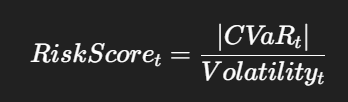

In [48]:
aligned_vol = vol_adjusted.loc[cvar_5.index]

risk_score = abs(cvar_5) / aligned_vol
risk_score

,0
Date,
2008-03-03,0.025067
2008-03-04,0.026905
2008-03-05,0.028600
2008-03-06,0.030217
2008-03-07,0.024412
...,...
2025-12-23,0.035366
2025-12-24,0.037099
2025-12-26,0.039160


In [49]:
kill_condition = cvar_5 < -0.03
kill_condition

,0
Date,
2008-03-03,False
2008-03-04,False
2008-03-05,False
2008-03-06,False
2008-03-07,False
...,...
2025-12-23,False
2025-12-24,False
2025-12-26,False


In [51]:
assets = ["SPY", "TLT", "GLD", "DBC", "UUP"]

returns_multi = returns_daily[assets].dropna()


In [52]:
rolling_corr = returns_multi.rolling(60).corr()
rolling_corr

SPY       TLT       GLD       DBC       UUP
Date                                                            
2007-03-02 SPY       NaN       NaN       NaN       NaN       NaN
           TLT       NaN       NaN       NaN       NaN       NaN
           GLD       NaN       NaN       NaN       NaN       NaN
           DBC       NaN       NaN       NaN       NaN       NaN
           UUP       NaN       NaN       NaN       NaN       NaN
...                  ...       ...       ...       ...       ...
2025-12-30 SPY  1.000000 -0.095481  0.166899  0.419813  0.051051
           TLT -0.095481  1.000000 -0.091996 -0.313189 -0.352445
           GLD  0.166899 -0.091996  1.000000  0.410659 -0.173492
           DBC  0.419813 -0.313189  0.410659  1.000000  0.007590
           UUP  0.051051 -0.352445 -0.173492  0.007590  1.000000

[23705 rows x 5 columns]

In [54]:
import numpy as np

def compute_avg_corr(corr_matrix, date):
    mat = corr_matrix.loc[date].values
    upper_triangle = mat[np.triu_indices_from(mat, k=1)]
    return np.mean(np.abs(upper_triangle))

dates = returns_multi.index[59:]
avg_corr_series = []

for date in dates:
    avg_corr_series.append(
        compute_avg_corr(rolling_corr, date)
    )

avg_corr_series = pd.Series(avg_corr_series, index=dates)
avg_corr_series

,0
Date,
2007-05-25,0.290255
2007-05-29,0.268283
2007-05-30,0.238625
2007-05-31,0.225452
2007-06-01,0.230849
...,...
2025-12-23,0.200221
2025-12-24,0.201141
2025-12-26,0.202002


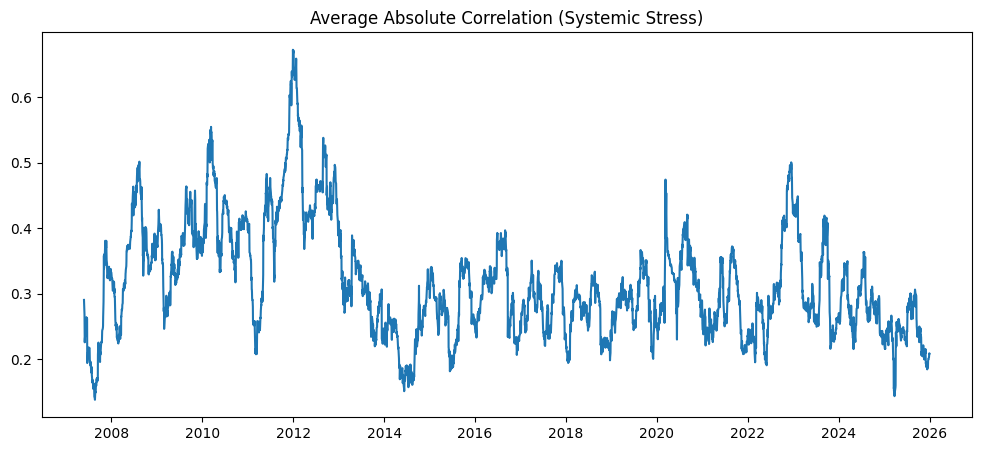

In [55]:
plt.figure(figsize=(12,5))
plt.plot(avg_corr_series)
plt.title("Average Absolute Correlation (Systemic Stress)")
plt.show()


In [56]:
def network_density(corr_matrix, date, threshold=0.6):
    mat = np.abs(corr_matrix.loc[date].values)
    n = mat.shape[0]

    strong_edges = np.sum(mat > threshold) - n  # remove diagonal
    possible_edges = n*(n-1)

    return strong_edges / possible_edges

density_series = []

for date in dates:
    density_series.append(
        network_density(rolling_corr, date)
    )

density_series = pd.Series(density_series, index=dates)


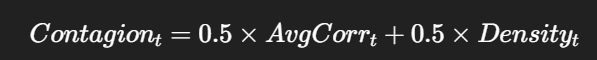

In [58]:
contagion_index = 0.5*avg_corr_series + 0.5*density_series
contagion_index

,0
Date,
2007-05-25,0.145128
2007-05-29,0.134142
2007-05-30,0.119312
2007-05-31,0.112726
2007-06-01,0.115425
...,...
2025-12-23,0.100111
2025-12-24,0.100570
2025-12-26,0.101001


In [59]:
contagion_index = contagion_index.to_frame("contagion")

contagion_index["regime"] = daily_regime.loc[contagion_index.index]


In [60]:
assets = ["SPY", "TLT", "GLD", "DBC", "UUP"]

returns_multi = returns_daily[assets].dropna()


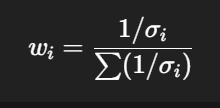

In [62]:
rolling_vol = returns_multi.rolling(60).std()
rolling_vol

,SPY,TLT,GLD,DBC,UUP
Date,,,,,
2007-03-02,NaN,NaN,NaN,NaN,NaN
2007-03-05,NaN,NaN,NaN,NaN,NaN
2007-03-06,NaN,NaN,NaN,NaN,NaN
2007-03-07,NaN,NaN,NaN,NaN,NaN
2007-03-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-12-23,0.008108,0.005165,0.014831,0.008254,0.002926
2025-12-24,0.008107,0.005213,0.014837,0.008233,0.002921
2025-12-26,0.008099,0.005219,0.014883,0.008233,0.002920


In [63]:
inv_vol = 1 / rolling_vol
weights_base = inv_vol.div(inv_vol.sum(axis=1), axis=0)


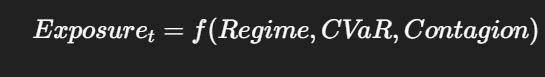

In [64]:
exposure = pd.Series(1.0, index=weights_base.index)

# Regime-based scaling
regime_scaling = {
    0: 1.2,  # Expansion
    1: 1.0,  # Neutral
    2: 0.5,  # Crisis
    3: 0.8   # Recovery
}

regime_daily = daily_regime.loc[weights_base.index]
exposure *= regime_daily.map(regime_scaling)

# CVaR constraint
cvar_aligned = cvar_5.reindex(weights_base.index).fillna(method="ffill")
exposure[cvar_aligned < -0.03] *= 0.5

# Contagion constraint
contagion_aligned = contagion_index.reindex(weights_base.index).fillna(method="ffill")
exposure[contagion_aligned["contagion"] > 0.65] *= 0.7


/tmp/ipython-input-2621458683.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cvar_aligned = cvar_5.reindex(weights_base.index).fillna(method="ffill")
/tmp/ipython-input-2621458683.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  contagion_aligned = contagion_index.reindex(weights_base.index).fillna(method="ffill")


In [66]:
weights_final = weights_base.multiply(exposure, axis=0)
weights_final

,SPY,TLT,GLD,DBC,UUP
Date,,,,,
2007-03-02,NaN,NaN,NaN,NaN,NaN
2007-03-05,NaN,NaN,NaN,NaN,NaN
2007-03-06,NaN,NaN,NaN,NaN,NaN
2007-03-07,NaN,NaN,NaN,NaN,NaN
2007-03-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-12-23,0.145550,0.228494,0.079574,0.142985,0.403397
2025-12-24,0.145738,0.226628,0.079625,0.143501,0.404506
2025-12-26,0.145919,0.226445,0.079406,0.143555,0.404675


In [67]:
portfolio_returns = (weights_final.shift(1) * returns_multi).sum(axis=1)
portfolio_returns

,0
Date,
2007-03-02,0.000000
2007-03-05,0.000000
2007-03-06,0.000000
2007-03-07,0.000000
2007-03-08,0.000000
...,...
2025-12-23,0.002331
2025-12-24,0.001654
2025-12-26,0.000912


In [68]:
cagr = (1 + portfolio_returns).prod() ** (252/len(portfolio_returns)) - 1
vol = portfolio_returns.std() * np.sqrt(252)
max_dd = ( (1 + portfolio_returns).cumprod() /
           (1 + portfolio_returns).cumprod().cummax() - 1 ).min()


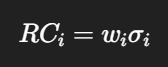

In [69]:
risk_contrib = weights_final * rolling_vol
risk_contrib

,SPY,TLT,GLD,DBC,UUP
Date,,,,,
2007-03-02,NaN,NaN,NaN,NaN,NaN
2007-03-05,NaN,NaN,NaN,NaN,NaN
2007-03-06,NaN,NaN,NaN,NaN,NaN
2007-03-07,NaN,NaN,NaN,NaN,NaN
2007-03-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-12-23,0.001180,0.001180,0.001180,0.001180,0.001180
2025-12-24,0.001181,0.001181,0.001181,0.001181,0.001181
2025-12-26,0.001182,0.001182,0.001182,0.001182,0.001182


In [71]:
hedge_signal = (
    (regime_daily == 2) |
    (cvar_aligned < -0.035) |
    (contagion_aligned["contagion"] > 0.70)
)
hedge_signal

,0
Date,
2007-03-02,False
2007-03-05,False
2007-03-06,False
2007-03-07,False
2007-03-08,False
...,...
2025-12-23,False
2025-12-24,False
2025-12-26,False


In [72]:
spot = (1 + returns_multi["SPY"]).cumprod()

strike = spot * 0.97

put_payoff = np.maximum(strike - spot, 0)


In [73]:
put_return = np.where(
    returns_multi["SPY"] < -0.03,
    abs(returns_multi["SPY"]),
    -0.005  # premium decay
)


In [74]:
hedge_weight = pd.Series(0.0, index=weights_final.index)

hedge_weight[hedge_signal] = 0.05


In [75]:
weights_hedged = weights_final.copy()
weights_hedged["SPY"] -= hedge_weight


In [76]:
portfolio_returns_hedged = (
    (weights_hedged.shift(1) * returns_multi).sum(axis=1)
)

portfolio_returns_hedged += hedge_weight.shift(1) * put_return


In [77]:
hedge_frequency = hedge_signal.mean()


In [80]:
import pandas as pd

# Recreate the index from when macro_regime_df had 137 rows, before the SPY join.
# This index aligns with the 'regimes' and 'regime_probs' arrays.
# We reconstruct the 'macro_regime_df' as it was just after dropna() and before the SPY join.
temp_macro_regime_df_before_spy_join = macro_monthly.join(vix_monthly, how="inner")
temp_macro_regime_df_before_spy_join.dropna(inplace=True)
initial_regime_index_for_probs = temp_macro_regime_df_before_spy_join.index

# Create the DataFrame for regime_probs using this correct 137-row index.
# Then reindex it to the current macro_regime_df.index (127 rows).
regime_probs_aligned = pd.DataFrame(
    regime_probs,
    index=initial_regime_index_for_probs,
    columns=[f"regime_{i}" for i in range(4)]
).reindex(macro_regime_df.index)

regime_probs_df = regime_probs_aligned

crisis_prob = regime_probs_df["regime_2"]  # assuming 2 = crisis

crisis_prob_daily = crisis_prob.reindex(weights_final.index, method="ffill")

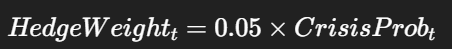

In [81]:
hedge_weight = 0.05 * crisis_prob_daily


In [82]:
tail_condition = (
    (cvar_aligned < -0.035) |
    (contagion_aligned["contagion"] > 0.65)
)

hedge_weight = hedge_weight.where(tail_condition, 0)


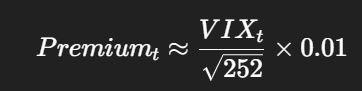

In [83]:
vix_aligned = vix.reindex(weights_final.index, method="ffill")

daily_premium = (vix_aligned / np.sqrt(252)) * 0.0001


In [84]:
put_return = np.where(
    returns_multi["SPY"] < -0.02,
    abs(returns_multi["SPY"]) * 1.5,
    -daily_premium
)


In [85]:
weights_hedged = weights_final.copy()
weights_hedged["SPY"] -= hedge_weight


In [87]:
portfolio_returns_hedged = (
    (weights_hedged.shift(1) * returns_multi).sum(axis=1)
)

# Ensure put_return is 1-dimensional before multiplication
# By inspecting the kernel state for 'put_return', it appears all columns are identical for each row.
# We can extract the first column to get the intended 1-dimensional data.
portfolio_returns_hedged += hedge_weight.shift(1) * put_return[:, 0]


In [88]:
def max_drawdown(series):
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    return ((cum - peak) / peak).min()

print("Unhedged DD:", max_drawdown(portfolio_returns))
print("Hedged DD:", max_drawdown(portfolio_returns_hedged))


Unhedged DD: -0.06137237690030471
Hedged DD: -0.061372376900304566


In [89]:
stress_periods = [
    ("2008-01-01", "2009-12-31"),
    ("2020-02-01", "2020-06-30"),
    ("2022-01-01", "2022-12-31")
]

for start, end in stress_periods:
    sub = portfolio_returns_hedged.loc[start:end]
    print(start, end, "DD:", max_drawdown(sub))


2008-01-01 2009-12-31 DD: -0.0497385241132732
2020-02-01 2020-06-30 DD: -0.06137237690030457
2022-01-01 2022-12-31 DD: -0.06067529641764341


In [90]:
from scipy.stats import t

df = 4  # heavy tails
simulations = []

for _ in range(5000):
    sim_returns = t.rvs(df, size=252) * portfolio_returns.std()
    simulations.append(sim_returns.sum())

simulations = np.array(simulations)



In [91]:
np.percentile(simulations, 1)


np.float64(-0.13574477320089595)

In [92]:
shock = -0.05  # 5% simultaneous drop

shock_returns = pd.DataFrame(
    shock,
    index=returns_multi.index[:10],
    columns=returns_multi.columns
)

shock_portfolio = (weights_final.iloc[0] * shock_returns.iloc[0]).sum()


In [93]:
vol_shock = vol_adjusted * 3
risk_score_shock = abs(cvar_5) / vol_shock
